In [27]:
# load fashion mnist dataset
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
from collections import Counter

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import networkx as nx
from networkx.algorithms import node_classification
from karateclub import DeepWalk, Node2Vec, NetMF, LaplacianEigenmaps

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)


In [ ]:
# load dataset 
img_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.5), std=(0.5))])
training_data = datasets.FashionMNIST(root="./data", train=True, download=True, transform=img_transform)
test_data = datasets.FashionMNIST(root="./data", train=False, download=True, transform=img_transform)

In [2]:
def get_class_images(training_data, num, class_num):
    return random.sample([(img, label) for img, label in training_data if label == class_num], num)

# random sampling 500 images from class 4 and 9 
training_data_4 = get_class_images(training_data, 500, 4)
training_data_9 = get_class_images(training_data, 500, 9)
training_data = training_data_4 + training_data_9 # concat two classes

# print number of count of each class
unique_labels = set([label for _, label in training_data])
for label in unique_labels:
    cnt = sum([1 for _, l in training_data if l == label])
    print(f"{label}: {cnt}")
 

9: 500
4: 500


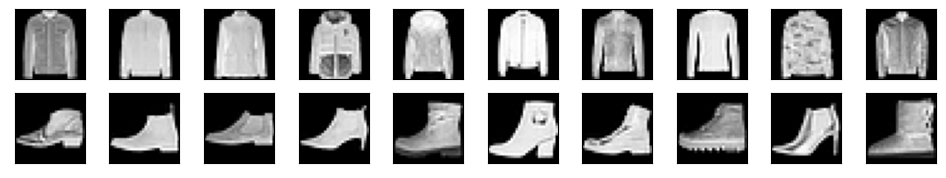

In [3]:
sample_data = get_class_images(test_data, 10, 4) + get_class_images(test_data, 10, 9)

# plot 10 images of each class
fig = plt.figure(figsize=(12, 2))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(sample_data[idx][0].reshape(28,28), cmap='gray')
    # ax.set_title(str(test_data[idx][1]))

In [4]:
# 1. Graph generation
# Construct a graph having 1000 nodes, where each node corresponds to an image and an edge is added between two nodes if the two images are sufficiently similar.
# Here, one way to define the similarity between images is the inner product of the (vectorized) images. 
# A threshold can be used to determine whether to put an edge or not, i.e.

mean: 0.3434864580631256, median: 0.3123701214790344


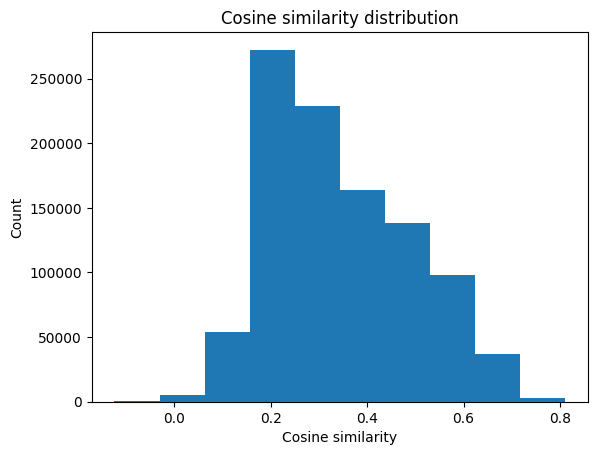

In [38]:
X = np.array([np.array(img.reshape(-1)) for img, _ in training_data])
# cosine s|imilarity between images, len(X[0]) is the number of pixels in each image
cosine_similarity = np.dot(X, X.T) / len(X[0]) 
np.fill_diagonal(cosine_similarity, 0)

hist = plt.hist(cosine_similarity.flatten(), bins=10)
plt.title("Cosine similarity distribution")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.savefig("cosine_similarity_distribution.png")

mean_cs = np.mean(cosine_similarity) # mean of cosine similarity
median_cs = np.median(cosine_similarity) # median of cosine similarity
print(f"mean: {mean_cs}, median: {median_cs}")

In [39]:
threshold = 0.3 # 0.3413
weighted_matrix = np.where(cosine_similarity > threshold, cosine_similarity, 0)
unweighted_matrix = np.where(cosine_similarity > threshold, 1, 0)

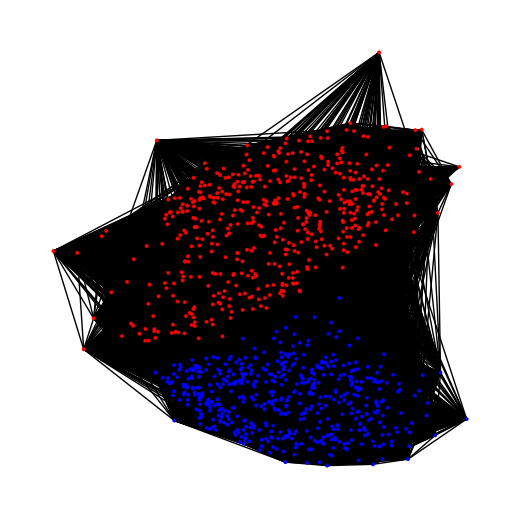

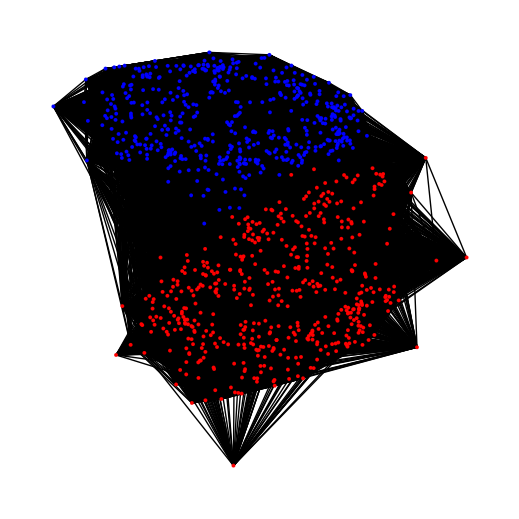

In [40]:
# weighted graph 
colors_map = {4: 'red', 9: 'blue'} 
colors = [colors_map[label] for _, label in training_data]

weighted_G = nx.from_numpy_matrix(weighted_matrix)
unweighted_G = nx.from_numpy_matrix(unweighted_matrix)

fig = plt.figure(figsize=(5, 5))
nx.draw(weighted_G, with_labels=False, node_size=7, node_color=colors, linewidths=0.1)
plt.savefig("weighted_graph(all).png")

fig = plt.figure(figsize=(5, 5))
nx.draw(unweighted_G, with_labels=False, node_size=7, node_color=colors, linewidths=0.1)
plt.savefig("unweighted_graph(all).png")

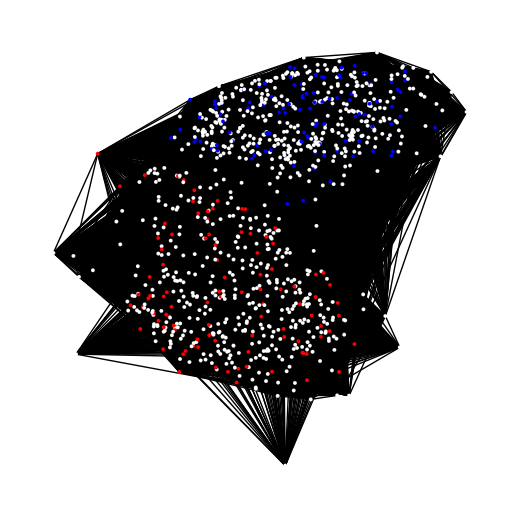

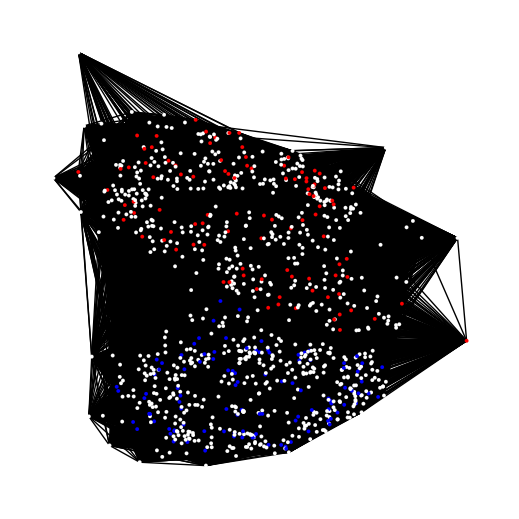

In [41]:
p = 0.2 # 20% of training data
train_index = np.random.choice(len(training_data), int(len(training_data) * p), replace=False)
test_index = [i for i in range(len(training_data)) if i not in train_index]
train_colors = ['white' if i not in train_index else colors[i] for i in range(len(training_data))]
Counter(train_colors)

fig = plt.figure(figsize=(5, 5))
nx.draw(weighted_G, with_labels=False, node_size=7, node_color=train_colors, linewidths=0.1)
plt.savefig("weighted_graph(train).png")

fig = plt.figure(figsize=(5, 5))
nx.draw(unweighted_G, with_labels=False, node_size=7, node_color=train_colors, linewidths=0.1)
plt.savefig("unweighted_graph(train).png")

In [42]:
# mean degree 
print(f"mean degree of weighted graph: {np.mean(list(dict(weighted_G.degree()).values()))}")
print(f"mean degree of unweighted graph: {np.mean(list(dict(unweighted_G.degree()).values()))}")
# centrality
print(f"mean centrality of weighted graph: {np.mean(list(nx.closeness_centrality(weighted_G).values()))}")
print(f"mean centrality of unweighted graph: {np.mean(list(nx.closeness_centrality(unweighted_G).values()))}")

mean degree of weighted graph: 526.882
mean degree of unweighted graph: 526.882
mean centrality of weighted graph: 0.6804617813718578
mean centrality of unweighted graph: 0.6804617813718578


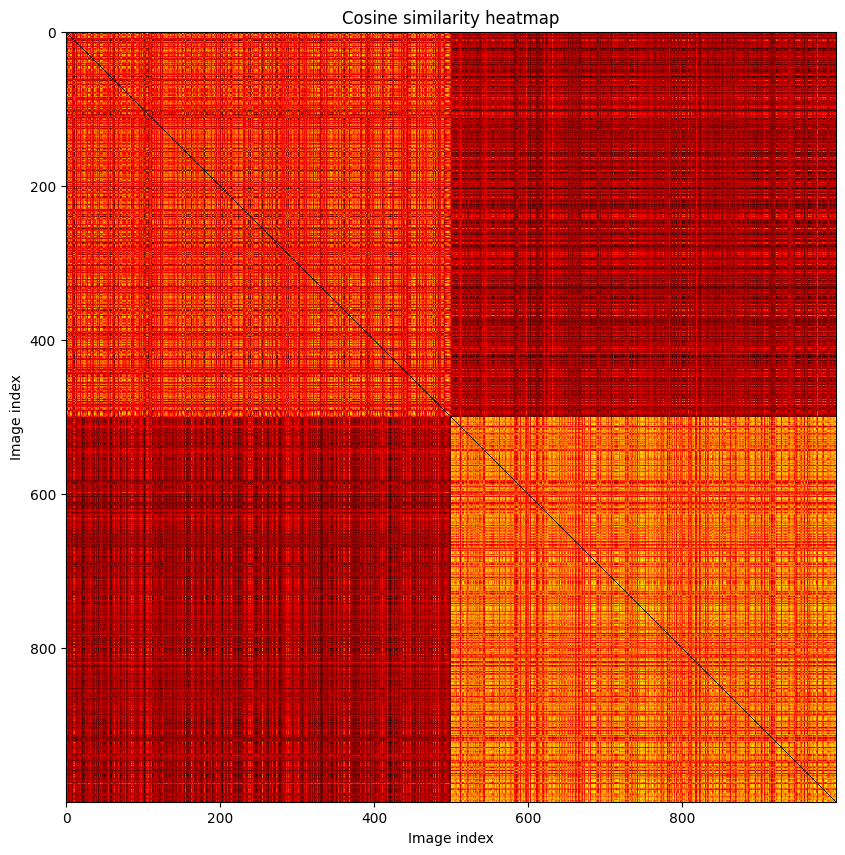

In [43]:
# heatmap of cosine similarity matrix
plt.figure(figsize=(10, 10))
plt.imshow(cosine_similarity, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
plt.title("Cosine similarity heatmap")
plt.xlabel("Image index")
plt.ylabel("Image index")
plt.savefig("cosine_similarity_heatmap.png")


In [44]:
# where x_i is the ith image after vectorization, and h and w are the height and width of an image, 
# respectively. A reasonable choice of the threshold could be 0.15 (but you can freely change it). You can 
# also try a weighted graph by assigning the similarity (after some scaling if necessary) as the edge weight

In [45]:
# Temporary save
df = pd.DataFrame(weighted_matrix)
df.to_csv('weighted_graph.csv', index=False, header=False)
df = pd.DataFrame(unweighted_matrix)
df.to_csv('unweighted_graph.csv', index=False, header=False)

In [16]:
# Choose randomly p% of the nodes as labeled (training) nodes. 
# Your goal is to predict the classes of the (100 − P)% unlabeled nodes. Try P=20%, 50%, and 80%

In [46]:
for i in range(len(training_data)):
    if i in train_index:
        weighted_G.nodes[i]['label'] = training_data[i][1]
        unweighted_G.nodes[i]['label'] = training_data[i][1]

In [21]:
# 2. Node classification methods
# Apply the following node classification methods that were introduced during the class:
# • Label propagation (you can use
# networkx.algorithms.node_classification.harmonic_function)
# • Label spreading (you can use
# networkx.algorithms.node_classification.local_and_global_consistency)
# You can also additionally try other node classification methods, no matter whether they were 
# mentioned in the class or not. If needed, you can use existing packages and libraries

In [290]:
def node_classification_harmonic_function(G, training_data, training_nodes, unlabeled_nodes):
    acc, count, total = 0, 0, 0
    predicted = node_classification.harmonic_function(G)
    for i in range(len(training_data)):
        if i in training_nodes:
            continue
        if predicted[i] == training_data[i][1]:
            count += 1
        total += 1
    acc = count / total
    print(f"count: {count}, total: {total}, acc: {acc}")
    return acc

def node_classification_local_and_global_consistency(G, training_data, training_nodes, unlabeled_nodes):
    acc, count, total = 0, 0, 0
    predicted = node_classification.local_and_global_consistency(G)
    for i in range(len(training_data)):
        if i in training_nodes:
            continue
        if predicted[i] == training_data[i][1]:
            count += 1
        total += 1
    acc = count / total
    print(f"count: {count}, total: {total}, acc: {acc}")
    return acc


In [291]:
# weighted graph
acc = node_classification_harmonic_function(weighted_G, training_data, train_index, test_index)
print(f"harmonic function acc: {acc}")
acc = node_classification_local_and_global_consistency(weighted_G, training_data, train_index, test_index)
print(f"local_and_global_consistency acc: {acc}")

# unweighted graph
acc = node_classification_harmonic_function(unweighted_G, training_data, train_index, test_index)
print(f"harmonic function acc: {acc}")
acc = node_classification_local_and_global_consistency(unweighted_G, training_data, train_index, test_index)
print(f"local_and_global_consistency acc: {acc}")


count: 753, total: 800, acc: 0.94125
harmonic function acc: 0.94125
count: 736, total: 800, acc: 0.92
local_and_global_consistency acc: 0.92
count: 752, total: 800, acc: 0.94
harmonic function acc: 0.94
count: 728, total: 800, acc: 0.91
local_and_global_consistency acc: 0.91


In [ ]:
# 3. Node embedding + machine learning
# Another way to solve the problem is to perform node embedding to extract features of the nodes, 
# train a classifier with the features of the labeled (training) nodes, and perform classification using the 
# trained model for the features of the unlabeled (test) nodes. You can choose any supervised machine 
# learning model as the classifier, e.g., multi-layer perceptron, support vector machine, k-nearest 
# neighbor classifier, decision tree, random forest, etc.
# Try at least one node embedding method among
# • Locally linear embedding
# • Laplacian eigenmap
# • Graph factorization
# • Deepwalk
# • Node2vec
# • Large-scale information network embedding (LINE)
# If needed, you can use existing packages and libraries

In [28]:
DeepWalk_model = DeepWalk(walk_number=10, walk_length=80, dimensions=128, workers=8)
DeepWalk_model.fit(weighted_G)
dw_embedding = DeepWalk_model.get_embedding()

with open('dw_embedding.pickle', 'wb') as f:
    pickle.dump(dw_embedding, f)

In [51]:
Node2Vec_model = Node2Vec()
Node2Vec_model.fit(weighted_G)
nv_embedding = Node2Vec_model.get_embedding()

with open('nv_embedding.pickle', 'wb') as f:
    pickle.dump(nv_embedding, f)

In [29]:
LaplacianEigenmaps_model = LaplacianEigenmaps()
LaplacianEigenmaps_model.fit(weighted_G)
le_embedding = LaplacianEigenmaps_model.get_embedding()

with open('le_embedding.pickle', 'wb') as f:
    pickle.dump(le_embedding, f)

In [47]:
NetMF_model = NetMF()
NetMF_model.fit(weighted_G)
nmf_embedding = NetMF_model.get_embedding()

with open('nmf_embedding.pickle', 'wb') as f:
    pickle.dump(nmf_embedding, f)

In [26]:
# load embedding from pickle
with open('nv_embedding.pickle', 'rb') as f:
    nv_embedding = pickle.load(f)

with open('dw_embedding.pickle', 'rb') as f:
    dw_embedding = pickle.load(f)

with open('le_embedding.pickle', 'rb') as f:
    le_embedding = pickle.load(f)
    
with open('nmf_embedding.pickle', 'rb') as f:
    nmf_embedding = pickle.load(f)

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import time

def get_acc_logistic_regression(embedding, labels, test_size=0.3, random_state=42):
    start_time = time.time() 
    x_train, x_test, y_train, y_test = train_test_split(embedding, labels, test_size=test_size, random_state=random_state)
    ML_model = LogisticRegression(random_state=0).fit(x_train, y_train)
    y_predict = ML_model.predict(x_test)
    accuracy = ML_model.score(x_test, y_test)
    print(f"running time: {time.time() - start_time}")
    return accuracy

def get_acc_svm(embedding, labels, test_size=0.3, random_state=42):
    start_time = time.time() 
    x_train, x_test, y_train, y_test = train_test_split(embedding, labels, test_size=test_size, random_state=random_state)
    ML_model = SVC(kernel='linear', C=1).fit(x_train, y_train)
    y_predict = ML_model.predict(x_test)
    accuracy = ML_model.score(x_test, y_test)
    print(f"running time: {time.time() - start_time}")
    return accuracy

def get_acc_random_forest(embedding, labels, test_size=0.3, random_state=42):
    start_time = time.time() 
    x_train, x_test, y_train, y_test = train_test_split(embedding, labels, test_size=test_size, random_state=random_state)
    ML_model = RandomForestClassifier(max_depth=2, random_state=0).fit(x_train, y_train)
    y_predict = ML_model.predict(x_test)
    accuracy = ML_model.score(x_test, y_test)
    print(f"running time: {time.time() - start_time}")
    return accuracy

def get_acc_multi_layer_perceptron(embedding, labels, test_size=0.3, random_state=42):
    start_time = time.time() 
    x_train, x_test, y_train, y_test = train_test_split(embedding, labels, test_size=test_size, random_state=random_state)
    ML_model = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', \
                    solver='sgd', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.001, max_iter=500).fit(x_train, y_train)
    y_predict = ML_model.predict(x_test)
    accuracy = ML_model.score(x_test, y_test)
    print(f"running time: {time.time() - start_time}")
    return accuracy


In [49]:
def get_acc_all_methods(embedding, labels, test_size=0.3, random_state=42):
    acc = {}
    acc['logistic_regression'] = get_acc_logistic_regression(embedding, labels, test_size, random_state)
    acc['svm'] = get_acc_svm(embedding, labels, test_size, random_state)
    acc['random_forest'] = get_acc_random_forest(embedding, labels, test_size, random_state)
    acc['multi_layer_perceptron'] = get_acc_multi_layer_perceptron(embedding, labels, test_size, random_state)
    return acc

In [37]:
acc = get_acc_all_methods(dw_embedding, labels)
print(acc)
acc = get_acc_all_methods(nv_embedding, labels)
print(acc)
acc = get_acc_all_methods(le_embedding, labels)
print(acc)


running time: 0.12106180191040039
running time: 0.017496824264526367
running time: 0.411135196685791
running time: 15.435050964355469
{'logistic_regression': 1.0, 'svm': 1.0, 'random_forest': 0.9966666666666667, 'multi_layer_perceptron': 1.0}
running time: 0.11743307113647461
running time: 0.013088703155517578
running time: 0.3954739570617676
running time: 17.51892900466919
{'logistic_regression': 0.9966666666666667, 'svm': 0.9966666666666667, 'random_forest': 0.99, 'multi_layer_perceptron': 0.9966666666666667}
running time: 0.030755281448364258
running time: 0.13309144973754883
running time: 0.3616359233856201
running time: 77.734787940979
{'logistic_regression': 0.9966666666666667, 'svm': 0.99, 'random_forest': 0.9733333333333334, 'multi_layer_perceptron': 0.9933333333333333}
running time: 0.025267839431762695
running time: 0.09896183013916016
running time: 0.24649500846862793
running time: 56.8334424495697
{'logistic_regression': 0.56, 'svm': 0.5533333333333333, 'random_forest': 0.5

In [50]:
acc = get_acc_all_methods(nmf_embedding, labels)
print(acc)



running time: 0.04685711860656738
running time: 0.0976572036743164
running time: 0.23297715187072754
running time: 54.48831105232239
{'logistic_regression': 0.56, 'svm': 0.5533333333333333, 'random_forest': 0.5666666666666667, 'multi_layer_perceptron': 0.5666666666666667}
